In [ ]:
!pip install datasets

In [2]:
import datasets

In [4]:
from datasets import Features, Value, ClassLabel
from datasets import load_dataset, Image

class_names = ['image']
ft = Features({'image': Image(decode=True, id=None), 'label': ClassLabel(names=['625819a92a2466ab6181a2fb5271ae99c740b4f0e4b9bc97bcfa01ef4ed9666f', '739a87d55867610f9341b5706e0702effaca6404b58a85184530e97674925c11', '912b0ea8f91a77c03100a11b064c6352c96b157402b302f1d4e2fdd0b19ca0da', 'c130f98c73856f51a8a5d53d5566171b4f3b2b64b733b9392b3a4c4387af0208', 'ca0306348357abce2f22db92a9d60f3c7d65a4b6a94e9f8b596b33c0bb41d22c'], id=None)})

dataset = load_dataset("DucHaiten/PIXAR-SDXL", features=ft)

Generating train split:   0%|          | 0/1851 [00:00<?, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1851
    })
})

In [6]:
train_dataset = dataset['train']

In [7]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1851
})

In [8]:
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms
transform = transforms.Resize((1024,1024))

class PixarDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = np.asarray(item["image"]).astype(np.float32)/255.0
        image = torch.from_numpy(image).permute(2, 0, 1)
        image = transform(image)
        return image

In [9]:
trainDataset = PixarDataset(dataset=train_dataset)

In [10]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(trainDataset, batch_size=2, shuffle=True)

In [11]:
import torch
import torch.nn as nn

In [12]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=(1, 1), kernel_size=(5, 5), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(3, 3), kernel_size=(5, 5), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(3, 3), kernel_size=(5, 5), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(5, 5), padding=1)
        )

        # Decoder
        self.decoder = nn.Sequential(
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(5, 5), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(3, 3), kernel_size=(5, 5), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(3, 3), kernel_size=(5, 5), padding=0, output_padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 3, stride=(1, 1), kernel_size=(5, 5), padding=0),
                nn.Sigmoid()
                )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encoding(self, x):
        x = self.encoder(x)
        return x

    def decode(self, x):
        x = self.decoder(x)
        return x


In [13]:
model = Autoencoder().cuda()
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
train_loss_history = []

for epoch in range(500):
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_dataloader):
        images = data
        images = images.cuda()
        labels = images.cuda()
        optimizer.zero_grad()
        predicted_labels = model(images) ## forward pass
        fit = loss(predicted_labels, labels)  ## calculate loss
        fit.backward() ## backprop
        optimizer.step()  ## calculate gradients and updates weights
        train_loss += fit.item()

    train_loss = train_loss/len(train_dataloader)
    train_loss_history.append(train_loss)

    print(f'Epochs {epoch}, Train loss: {train_loss}')

    if train_loss<0.001:
        break

In [ ]:
torch.save(model.state_dict(), 'model.pt')

### Inference

In [14]:
model.load_state_dict(torch.load("/content/model.pt"))

<All keys matched successfully>

In [15]:
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(64, 64, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(3, 3), output_padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(32, 3, kernel_size=(5, 5), stride=(1, 1))
    (7): Sigmoid()
  )
)

In [38]:
image = trainDataset[14]
image = image.cuda()

In [39]:
reconstructed = model(image)

In [40]:
import matplotlib.pyplot as plt

In [41]:
orig_image = (255*(image.permute(1,2,0))).cpu().numpy()
orig_image = orig_image.astype('uint8')

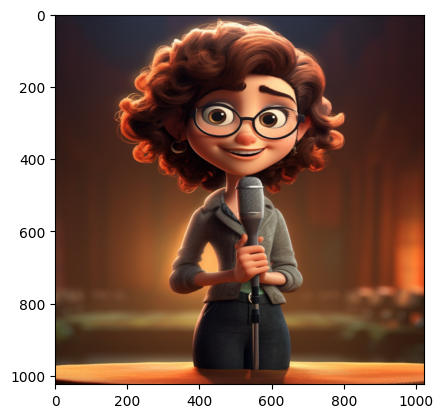

In [42]:
plt.imshow(orig_image)

In [43]:
from PIL import Image as im
data = im.fromarray(orig_image)
data.save('orig_image.png')

In [44]:
recon_image = (255*(reconstructed.permute(1,2,0))).cpu().detach().numpy()
recon_image = recon_image.astype('uint8')

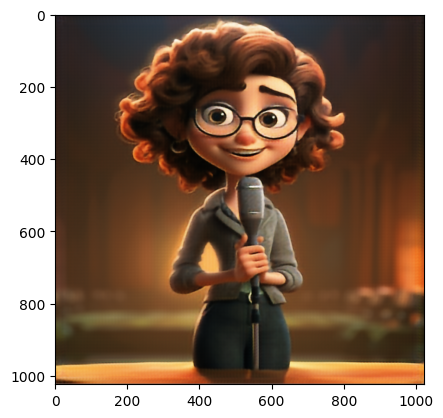

In [45]:
plt.imshow(recon_image)

In [46]:
from PIL import Image as im
data = im.fromarray(recon_image)
data.save('recon_image.png')